<a href="https://colab.research.google.com/github/akfangus/DeepProject/blob/main/CNN_Satellite_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
  # !sudo apt-get install -y fonts-nanum
  # !sudo fc-cache -fv
  # !rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (44.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [178]:
import numpy as np
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

In [4]:
%matplotlib inline
plt.rc('font', family='NanumBarunGothic')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path=[]

for i in os.listdir('/content/drive/MyDrive/Colab Notebooks/Satellite Image/data'):
  print(i)
  for item in glob(f'/content/drive/MyDrive/Colab Notebooks/Satellite Image/data/{i}/*'):
    path.append(item)

len(path)


desert
green_area
water
cloudy


5632

In [6]:
#{} 딕셔너리, 형태로 해당 경로에 있는 디렉토리를 sorting한다음에 인덱스순서대로 딕셔너리화
cmap = {v:i for i,v in enumerate(sorted(os.listdir('/content/drive/MyDrive/Colab Notebooks/Satellite Image/data')))}

In [7]:
cmap

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}

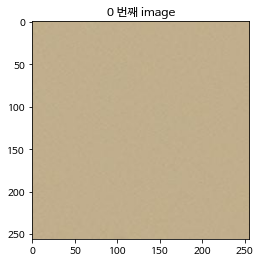

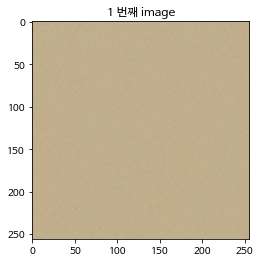

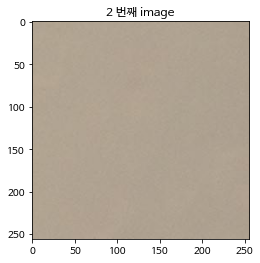

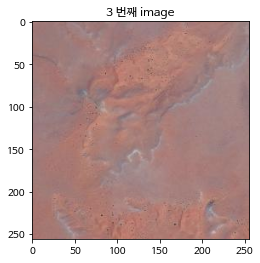

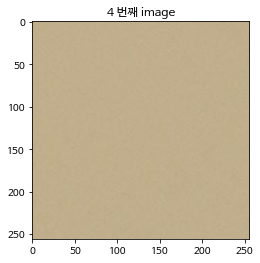

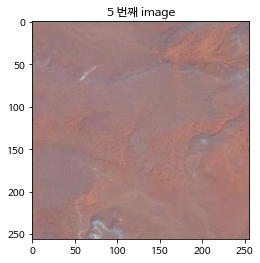

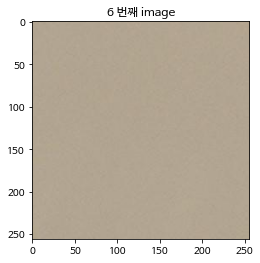

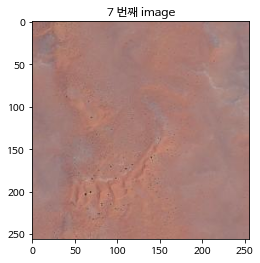

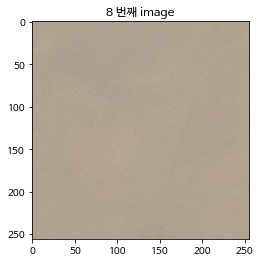

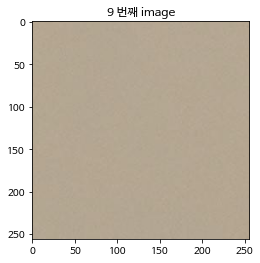

In [8]:
for i in range(10):
  plt.figure()
  imim = cv2.imread(path[i])[:,:,::-1]
  plt.imshow(imim)
  plt.title(f"{i} 번째 image")

plt.show()

In [ ]:
# trans = transforms.Compose([
#     transforms.ToTensor()])

# input = cv2.imread(path[0])
# print(input.shape)
# input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
# print(input.shape)
# input = trans(input)
# print(input.shape)

In [164]:
# VGG16 안쓴 일반 모델로 해보겟음   => VGG16과 비교? => normalize도 안하고 생이미지 그대로
class Satellite_Normal(Dataset):
  def __init__(self, path, cmap):
    # 클래스 초기화 함수
    self.path = path
    self.normalize = transforms.Compose([
                                         
              # transforms.Resize(256),              
              transforms.ToTensor(),
              # transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])                    
    ])
    self.cmap = cmap

  def __len__(self):
    return len(self.path)

  def __getitem__(self, ix):
    # size는 256*256
    im = cv2.imread(self.path[ix])    
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im,(256,256))
    # im = cv2.resize(im, ())
    # im  = torch.tensor(im/255)
    im = self.normalize(im)
    # im = im.permute(2,0,1)
    

  # 타겟 매핑
    target = self.path[ix].split('/')[-2]
    label = cmap[target]

    return im.float().to(device),torch.tensor(int(label)).long().to(device)




In [165]:
data = Satellite_Normal(path, cmap)

In [166]:
data[0][0].shape

torch.Size([3, 256, 256])

In [55]:
from random import shuffle
from random import seed

In [128]:
len(path)

5632

In [167]:
seed(42)
shuffle(path)

In [168]:
num = int(len(path) * 0.8)

In [169]:
train = path[:num]
val = path[num:]

train_data = Satellite_Normal(train, cmap)
val_data = Satellite_Normal(val, cmap)

train_dl = DataLoader(train_data, batch_size=32, shuffle = True, drop_last=True)
val_dl = DataLoader(val_data, batch_size=32, shuffle = False, drop_last=True)

In [64]:
device

'cuda'

In [170]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # self.keep_prob = 0.5
    self.layer1 = nn.Sequential(
        nn.Conv2d(3,32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer4 = nn.Sequential(
        nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc1 = nn.Sequential(
        # nn.Flatten(),
        nn.Linear(16*16*128,64),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.fc2 = nn.Sequential(
        nn.Linear(64,4),
        nn.Softmax()
    )
        # L5 Final FC 625 inputs -> 10 outputs
    # self.fc2 = torch.nn.Linear(625, 10, bias=True)
    # torch.nn.init.xavier_uniform_(self.fc2.weight)



  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)

    return out

In [136]:
model = CNN().to(device)

In [171]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [172]:
model.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=32768, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(i

In [173]:
from torchsummary import summary
# 만들어진 모델 어떻게 돌아가는지 테스트 및 성능 해보는거같음.
summary(model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
              ReLU-8          [-1, 128, 64, 64]               0
         MaxPool2d-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]         147,584
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Linear-13                   [-1, 64]       2,097,216
             ReLU-14                   

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [174]:
len(train_dl)

140

In [ ]:
for data, target in train_dl:
  print(data, target)

In [180]:
# 이제 학습 시켜보자
train_losses, valid_losses = [],[]
# 15epoch 수행 예정
n_epochs=5

for epochs in tqdm(range(n_epochs)):
  # train, val loss값 초기화
  train_loss=0.0
  val_loss=0.0
  # 모델을 학습 모드로 변환 / 평가 모드는 model.eval() 로 할 수 있다.
  model.train()
  for data, target in tqdm(train_dl):
    # 파이토치는 미분을 통해 얻은 기울기를 이전에 계산된 기울기 값에 누적시키는 특징이 있습니다
    # 그렇기 때문에 optimizer.zero_grad()를 통해 미분값을 계속 0으로 초기화
    optimizer.zero_grad()
    # data에 대한 예측값 생성
    prediction = model(data)
    # 예측과 target에 대한 loss function수행
    loss = loss_fn(prediction, target)
    # loss에 backwoar()를 계산하면 모델을 구성하는 파라미터에 대한 gradient를 계산한다.
    # backward()는 암묵적으로 loss값이 스칼라라고 가정하기때문에 scalar값으로 만들어주어야함.
    # backpropagation으로 하는듯.
    loss.backward()
    # optimizer가 step()메소드를 통해 parameter를 업데이터한다.
    optimizer.step()
    train_loss += loss.item() * data.size(0)

  # batch normalization 이나 dropout이 들어있는 모델은 batchsize에 따라 결과가 달라진다던가 실행 시킬때마다 결과가 달라져 학습에 영향을 미침 (드롭아웃 및 배치 정규화를 평가 모드로 설정하여야 합니다. 이것을 하지 않으면 추론 결과가 일관성 없게 출력)
  # 훈련후 결과 계산만을 위해 model.eval()을 실행 시켜줘야한다고함.
  model.eval()

  for data, target in val_dl:
    prediction = model(data)
    loss = loss_fn(prediction, target)
    val_loss += loss.item() * data.size(0)
  
  # for문에서 train_loss에 모든 loss의 합을 더햇으므로 최종 loss는 갯수만큼 나눠야겟죠?
  train_loss = train_loss / len(train_dl.sampler)
  val_loss = val_loss / len(val_dl.sampler)

  # loss 리스트에 append
  train_losses.append(train_loss)
  valid_losses.append(val_loss)

  print("Epoch : {} \tTraining Loss: {:.6f} \tValidation Loss {:.6f}".format(epochs,train_loss,val_loss))


  0%|          | 0/140 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

  0%|          | 0/5 [00:16<?, ?it/s]


KeyboardInterrupt: ignored

In [96]:
a = torch.zeros(1,3,256,256)
a.shape

torch.Size([1, 3, 256, 256])

In [108]:
c1 = nn.Conv2d(3,32, kernel_size=3, stride=1, padding=1)
c2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
c3 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)

ln1= nn.Linear(32*32*128,64)
ln2 = nn.Linear(64,4)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

In [109]:
out = c1(a)
print(out.shape)
out = pool1(out)
print(out.shape)

out = c2(out)
print(out.shape)
out = pool1(out)
print(out.shape)

out = c3(out)
print(out.shape)
out = pool1(out)
print(out.shape)


out = out.view(out.size(0), -1)
print(out.shape)

out = ln1(out)
print(out.shape)

out = ln2(out)
print(out.shape)


torch.Size([1, 32, 256, 256])
torch.Size([1, 32, 128, 128])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 131072])
torch.Size([1, 64])
torch.Size([1, 4])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 32, 128, 128])